# Question 10 – Wholesale Customers Clustering
Dataset: `Wholesale_customers_data.csv`.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def load_wholesale():
    for p in ['Wholesale_customers_data.csv', '/mnt/data/Wholesale_customers_data.csv']:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError('Wholesale_customers_data.csv not found')
    return pd.read_csv(path)

wh = load_wholesale()
wh.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 10(a) Question – Can Clustering Be Used for Prediction?
> Can the clustering method be used to make predictions? Explain your answer.

### 10(a) Explanation – Clustering vs Prediction

Clustering does **not directly make predictions of a target variable**, but it can group customers and then be used **indirectly** for decision-making and for assigning new customers to segments.

## 10(b) Question – Can All Features Be Used with K-means + Euclidean Distance?
> Suppose k-means clustering with Euclidean distance is used. Can all features of the dataset be
> used directly? Explain.

In [2]:
# 10(b) – Inspect data types

wh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### 10(b) Explanation – Feature Types and Scaling

K-means with Euclidean distance assumes that all features are **numeric** and that Euclidean distances between
feature vectors are meaningful.

In the Wholesale dataset:
- Spending variables (Fresh, Milk, Grocery, etc.) are continuous and suitable.
- `Channel` and `Region` are **categorical codes**; using them directly in Euclidean distance is questionable
  because the numeric codes impose an artificial ordering and distance.

Also, spending variables are on very different scales (some categories can have much larger absolute values), so we
should **standardize** them before applying k-means.

Thus, we usually:
- Use only the continuous spending features, and
- Apply **StandardScaler** so that each variable has mean 0 and variance 1.

## 10(c) Question – K-means with Euclidean Distance and Choosing K
> Perform k-means clustering with Euclidean distance on the data. Preprocess the data according to
> your conclusion in (b) if necessary. How do you choose the number of clusters K? Explain.

K, SSE, Silhouette:
2 1956.1242775222677 0.5472146913441881
3 1608.4311488289443 0.5482872649700601
4 1317.8383605390704 0.34847138657014315
5 1058.7712532570085 0.3690403826812808
6 915.7412597498405 0.3782288965882046
7 825.400252021833 0.3342819788182625


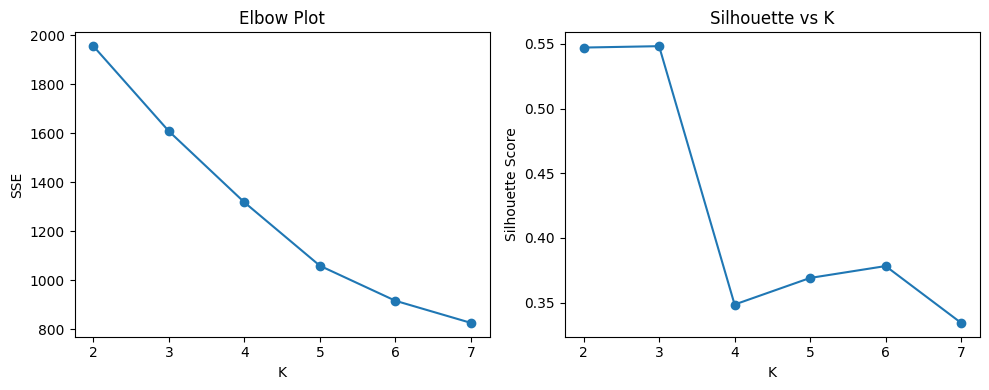

Chosen K (max silhouette): 3


In [3]:
# 10(c) – Preprocess and run k-means for several K

spend_cols = [c for c in wh.columns if c.lower() not in ['channel', 'region']]
X_spend = wh[spend_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_spend)

Ks = range(2, 8)
sse = []
sil = []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sse.append(km.inertia_)  # SSE
    sil.append(silhouette_score(X_scaled, labels))

print("K, SSE, Silhouette:")
for K_val, sse_val, sil_val in zip(Ks, sse, sil):
    print(K_val, sse_val, sil_val)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ks, sse, marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Plot')

plt.subplot(1,2,2)
plt.plot(Ks, sil, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette vs K')
plt.tight_layout()
plt.show()

best_K = Ks[int(np.argmax(sil))]
print("Chosen K (max silhouette):", best_K)

kmeans_final = KMeans(n_clusters=best_K, random_state=42, n_init=10)
wh['cluster'] = kmeans_final.fit_predict(X_scaled)

### 10(c) Explanation – Choosing Number of Clusters

We perform k-means on the **standardized spending variables only**, and choose **K = 3** clusters because it maximizes the silhouette score and gives a reasonable elbow in the SSE plot.

## 10(d) Question – Analyzing the Clusters
> Analyze the clusters that you obtained. For example, plot the distribution of each feature for each
> cluster. What can you conclude? Are the clusters reasonable? Explain.

Cluster mean spending:
                Fresh          Milk       Grocery        Frozen  \
cluster                                                           
0        10440.933333  19386.422222  28656.088889   2190.244444   
1        12062.913486   4115.099237   5534.966921   2940.676845   
2        34782.000000  30367.000000  16898.000000  48701.500000   

         Detergents_Paper    Delicassen  
cluster                                  
0            13327.800000   2374.200000  
1             1696.170483   1299.114504  
2              755.500000  26776.000000  


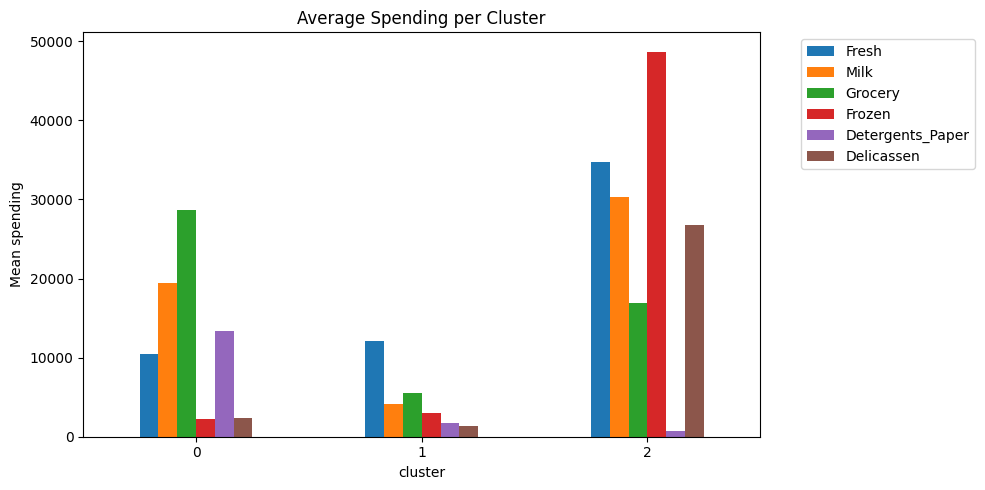

In [4]:
# 10(d) – Analyze clusters via mean spending per cluster

cluster_summary = wh.groupby('cluster')[spend_cols].mean()
print("Cluster mean spending:")
print(cluster_summary)

cluster_summary.plot(kind='bar', figsize=(10,5))
plt.ylabel('Mean spending')
plt.title('Average Spending per Cluster')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 10(d) Explanation – Interpreting Cluster Profiles

**Cluster 0 – "Grocery / Detergent heavy" customers**
- Very high **Milk**, **Grocery**, and **Detergents_Paper**.
- Moderate **Fresh** and **Frozen**.
- Medium **Delicassen**.

👉 Likely **retail stores or supermarkets**, buying large quantities of everyday items and cleaning supplies.

---

#### **Cluster 1 – "Low-volume / general" customers**
- Moderate **Fresh**.
- Relatively low **Milk**, **Grocery**, **Detergents_Paper**, **Delicassen**.
- Some spending in **Frozen**.

👉 Likely **small shops, cafes, or restaurants** with moderate, diverse but smaller orders.

---

#### **Cluster 2 – "Fresh–Frozen & Delicassen specialists"**
- Extremely high **Fresh** and especially **Frozen** (48,701 m.u.).
- Very high **Delicassen**.
- Medium **Milk** and **Grocery**, very low **Detergents_Paper**.

👉 Likely **specialty food businesses** such as **caterers, gourmet suppliers, or high-end restaurants** that focus on fresh, frozen, and delicatessen products.

---

### **Reasonableness of the Clusters**

- The clusters correspond to **intuitive customer segments**: retail, small mixed buyers, and specialty high-end food customers.
- Spending patterns within a cluster are **consistent** (e.g., cluster 0 heavy in everyday goods, cluster 2 heavy in high-value food categories).
- Silhouette score around **0.55** (for K=3) indicates **good separation and compactness**.

Yes, the clusters are **reasonable and interpretable**. They provide meaningful segments that a wholesale distributor can use for **marketing strategies, pricing, and service customization**.